# MNIST를 활용한 숫자 인식(MNIST: 손글씨 숫자 데이터셋)



In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchviz import make_dot
from torch import nn

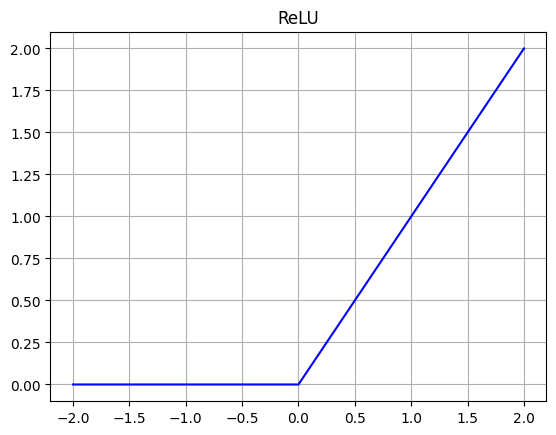

In [3]:
#ReLU 함수의 그래프
relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data, c='b')
plt.title('ReLU')
plt.grid()
plt.show()

#### 데이터 준비1(Dataset을 활용해 불러오기)

파이토치는 데이터 준비를 위한 도구를 상대적으로 잘 갖추고 있으며, 목적에 맞는 전용 클래스가 준비되어있음
* 데이터 입수: Dataset
* 데이터 전처리: Transforms
* 미니 배치용 데이터셋 생성: Dataloader

In [3]:
#URL에러 방지(예예)
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
#MNIST데이터 가져오기
import torchvision.datasets as datasets

#다운로드받을 디렉토리명
data_root = './data'

train_set0 = datasets.MNIST(
    #원본 데이터를 다운로드받을 디릭토리 지정
    root = data_root, 
    #훈련 데이터인지 또는 검증 데이터인지
    train = True, 
    #원본 데이터가 없는 경우, 다운로드를 실행하는지 여부
    download = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 934644.34it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 146962.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 495760.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4614953.67it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
!ls -lR ./data/MNIST

total 0
drwxr-xr-x  10 hataeho  staff  320 Jul 25 01:04 raw

./data/MNIST/raw:
total 132192
-rw-r--r--  1 hataeho  staff   7840016 Jul 25 01:04 t10k-images-idx3-ubyte
-rw-r--r--  1 hataeho  staff   1648877 Jul 25 01:04 t10k-images-idx3-ubyte.gz
-rw-r--r--  1 hataeho  staff     10008 Jul 25 01:04 t10k-labels-idx1-ubyte
-rw-r--r--  1 hataeho  staff      4542 Jul 25 01:04 t10k-labels-idx1-ubyte.gz
-rw-r--r--  1 hataeho  staff  47040016 Jul 25 01:04 train-images-idx3-ubyte
-rw-r--r--  1 hataeho  staff   9912422 Jul 25 01:04 train-images-idx3-ubyte.gz
-rw-r--r--  1 hataeho  staff     60008 Jul 25 01:04 train-labels-idx1-ubyte
-rw-r--r--  1 hataeho  staff     28881 Jul 25 01:04 train-labels-idx1-ubyte.gz


In [7]:
print('데이터 건수: ', len(train_set0))

image, label = train_set0[0]

print('입력 데이터 타입: ', type(image))
print('정답 데이터 타입', type(label))

데이터 건수:  60000
입력 데이터 타입:  <class 'PIL.Image.Image'>
정답 데이터 타입 <class 'int'>


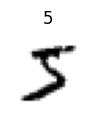

In [10]:
#입력 데이터를 이미지로 출력

plt.figure(figsize=(1, 1))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

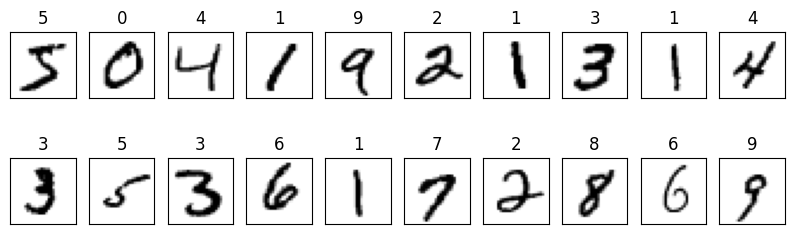

In [11]:
#정답 데이터와 함께 처음 20개를 데이터를 이미지로 출력

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)

    #image와 label 취득
    image, label = train_set0[i]

    #이미지 출력
    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

#### 데이터 준비 2(Transforms를 활용한 데이터 전처리)

In [13]:
import torchvision.transforms as transforms

transform1 = transforms.Compose([
    #텐서 변환
    transforms.ToTensor(),
])

train_set1 = datasets.MNIST(
    root = data_root,
    train=True,
    download=True,
    transform=transform1
)

In [14]:
# 변환 결과 확인

image, label = train_set1[0]
print('입력 데이터 타입: ', type(image))
print('입력 데이터 shape: ', image.shape)
print('최소값: ', image.data.min())
print('최대값: ', image.data.max())

입력 데이터 타입:  <class 'torch.Tensor'>
입력 데이터 shape:  torch.Size([1, 28, 28])
최소값:  tensor(0.)
최대값:  tensor(1.)


* $Normalize(\mu, \sigma)$ 로 원본 데이터 $\mathrm{x}$ 는 $\mathrm{X} = (\mathrm{x} - \mu) / \sigma$ 에 따라 변환됨
* 여기서 $\mu = \sigma = 0.5$ 로 변환하면, [-1, 1]의 범위 안의 값 $\mathbf{X}$ 로 변환 가능
* x = 0(최소)인 경우와 x = 1(최대)인 경우를 계산해보면, 실제로 그렇게 값이 변환된다는 것을 확인 가능

In [15]:
#학습 데이터의 범위가 [0, 1]로 정규화되어 있지만, 이 범위를 [-1, 1]으로 변경하려 함
#Normalize를 사용한 데이터 정규화

transform2 = transforms.Compose([ # Compose 클래스에 여러 개의 전처리를 리스트 형식으로 건네면, 각 처리를 순차적으로 수행하는 transform 인스턴스를 만들 수 있음
    #데이터를 텐서로 변환
    transforms.ToTensor(),

    #데이터 정규화
    transforms.Normalize(0.5, 0.5),
])

train_set2 = datasets.MNIST(
    root = data_root,
    train = True,
    download = True,
    transform = transform2
)


In [16]:
# 변환 결과 확인

image, label = train_set2[0]
print('입력 데이터 타입: ', type(image))
print('입력 데이터 shape: ', image.shape)
print('최소값: ', image.data.min())
print('최대값: ', image.data.max())

입력 데이터 타입:  <class 'torch.Tensor'>
입력 데이터 shape:  torch.Size([1, 28, 28])
최소값:  tensor(-1.)
최대값:  tensor(1.)


#### Lambda 클래스를 사용해 1차원으로 텐서 변환하기
* 전결합형 신경망에 입력하기 위해, 입력 변수의 shape를 원본 [1, 28, 28]에서 [784]로 변경

In [21]:
#입력 데이터의 shape변환
transform3 = transforms.Compose([
    transforms.ToTensor(),

    transforms.Normalize(0.5, 0.5),

    #현재 텐서를 1계 텐서로 변환
    transforms.Lambda(lambda x : x.view(-1)),
])

train_set3 = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
    transform=transform3
    )

* 제공하지 않은 처리를 구현하고 싶은 경우에는?
> 이런 경우를 위해 Lambda 클래스에 원하는 변환을 람다 표혀식으로 작성하면 그것이 가능

In [23]:
image, label = train_set3[0]
print('shape:', image.shape)
print('최소값: ', image.data.min())
print('최대값: ', image.data.max())

shape: torch.Size([784])
최소값:  tensor(-1.)
최대값:  tensor(1.)


In [2]:
#Transforms의 최종 정의
#데이터 변환용 함수 Transforms
#(1) image를 텐서로 변환
#(2) [0, 1] 범위의 값을 [-1, 1] 범위 안으로 정규화
#(3) 데이터의 shape을 [1, 28, 28]에서 [784]로 변환

transform = transforms.Compose([
    transforms.ToTensor(),

    transforms.Normalize(0.5, 0.5),

    transforms.Lambda(lambda x : x.view(-1))
])

In [3]:
#데이터셋 최종 정의
#데이터 취득 전용 함수 Dataset
data_root = './data'
#훈련 데이터셋 정의
train_set = datasets.MNIST(
    root = data_root,
    train=True,
    download=True,
    transform=transform
)


#검증 데이터셋 정의
test_set = datasets.MNIST(
    root = data_root,
    train=False,
    download=True,
    transform=transform
)

#### 데이터 준비 3(데이터로더를 활용한 미니 배치 데이터 생성)

In [4]:
from torch.utils.data import DataLoader

#미니 배치 사이즈 지정
batch_size = 500 #미니 배치 처리 한 번당 얼마나 많은 분량의 데이터를 취할 것인가

#훈련용 데이터 로더
#훈련용이므로, 셔플을 적용
train_loader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True
)

#검증용 데이터 로더
#검증시에는 셔플이 필요하지 않음
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

In [5]:
#몇 개의 그룹으로 데이터를 가져올 수 있는가
print(len(train_loader))

#데이터로부터 가장 처음 한 세트를 가져옴
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


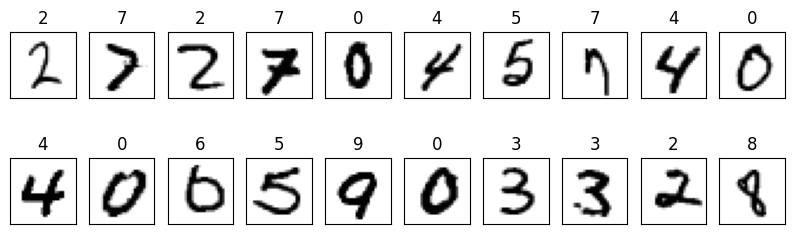

'\n데이터로더를 사용하면 대량의 학습 데이터를\n작은 단위로 분할할 수 있음\n'

In [6]:
# 이미지 출력
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # 넘파이로 배열로 변환
    image = images[i].numpy()
    label = labels[i]
    
    # 이미지의 범위를 [0, 1] 로 되돌림
    image2 = (image + 1)/ 2

    # 이미지 출력
    plt.imshow(image2.reshape(28, 28),cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

"""
데이터로더를 사용하면 대량의 학습 데이터를
작은 단위로 분할할 수 있음
"""

#### 모델 정의

In [7]:
n_input = image.shape[0]

n_output = len(set(list(labels.data.numpy())))

#은닉층의 노드 수
n_hidden = 128

print(f'n_input: {n_input}  n_output: {n_output}  n_hidden: {n_hidden}')

n_input: 784  n_output: 10  n_hidden: 128


In [8]:
#모델 정의
#784입력 10출력 1은닉층 신경망 모델
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        #은닉 층 정의
        self.l1 = nn.Linear(n_input, n_hidden)

        #출력 층 정의
        self.l2 = nn.Linear(n_hidden, n_output)        

        #ReLU함수 정의
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)

        x2 = self.relu(x1)

        x3 = self.l2(x2)

        return x3
    
    """
    선형함수의 출력에 대해서 활성화함수가 없는 것은,
    손실 함수 쪽에 softmax 함수를 포함할 예정이기 때문
    """

In [9]:
#난수고정(결과값 맞춰야함)
torch.manual_seed(123)

net = Net(n_input,  n_output,n_hidden)#.to(device) --> GPU사용

In [10]:
for param in net.named_parameters():
    print(param)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190,  0.0038,  0.033

In [16]:
print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


예측계산

In [11]:
for image, label in train_loader:
    break

inputs = images
labels = labels

outputs = net(inputs)

print(outputs)

tensor([[-0.2825, -0.2305,  0.2550,  ...,  0.0682,  0.3017,  0.0901],
        [-0.2511,  0.0060,  0.0248,  ...,  0.1720,  0.0496,  0.1887],
        [-0.3226, -0.0151,  0.2553,  ...,  0.1802,  0.0862,  0.0720],
        ...,
        [-0.3873, -0.1767,  0.0886,  ...,  0.2375,  0.0460,  0.1469],
        [-0.2737, -0.1530, -0.0665,  ..., -0.0088,  0.1176,  0.0640],
        [-0.0640, -0.2808,  0.0290,  ...,  0.0663,  0.0112, -0.1551]],
       grad_fn=<AddmmBackward0>)


2.3100085258483887


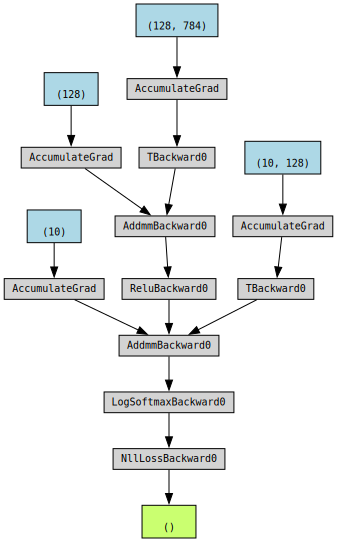

In [15]:
#  손실 계산
loss = criterion(outputs, labels)

# 손실값 가져오기
print(loss.item())

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [13]:
import torch.optim as optim

In [14]:
#초기화
torch.manual_seed(123)

lr = 0.01

net = Net(n_input, n_output, n_hidden)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr = lr)

num_epoch = 100

history = np.zeros((0, 5))

In [16]:
from tqdm.notebook import tqdm

In [17]:
#반복처리

#반복계산 메인 루프
for epoch in range(num_epoch):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    #train
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        predicted = torch.max(outputs, 1)[1]

        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()

    #predict
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        outputs_test = net(inputs_test)

        loss_test = criterion(outputs_test, labels_test)

        #예측 라벨 산출
        predicted_test = torch.max(outputs_test, 1)[1]

        val_loss += loss_test.item()
        val_acc += (predicted_test == labels_test).sum().item()
    
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test

    print (f'Epoch [{epoch+1}/{num_epoch}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch + 1, train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.82932 acc: 0.56960 val_loss: 1.32629, val_acc: 0.74660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/100], loss: 1.03889 acc: 0.79537 val_loss: 0.79661, val_acc: 0.83180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.70809 acc: 0.84110 val_loss: 0.60256, val_acc: 0.85850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.57300 acc: 0.86057 val_loss: 0.51192, val_acc: 0.87140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.50223 acc: 0.87102 val_loss: 0.45827, val_acc: 0.87930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.45883 acc: 0.87877 val_loss: 0.42422, val_acc: 0.88650


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.42938 acc: 0.88327 val_loss: 0.40076, val_acc: 0.88970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.40813 acc: 0.88743 val_loss: 0.38285, val_acc: 0.89370


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.39176 acc: 0.89065 val_loss: 0.36857, val_acc: 0.89680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.37875 acc: 0.89313 val_loss: 0.35741, val_acc: 0.89930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.36812 acc: 0.89593 val_loss: 0.34868, val_acc: 0.90160


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.35909 acc: 0.89785 val_loss: 0.34089, val_acc: 0.90220


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.35147 acc: 0.89977 val_loss: 0.33336, val_acc: 0.90490


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.34476 acc: 0.90130 val_loss: 0.32806, val_acc: 0.90570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.33860 acc: 0.90312 val_loss: 0.32334, val_acc: 0.90710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.33333 acc: 0.90410 val_loss: 0.31807, val_acc: 0.90790


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.32843 acc: 0.90522 val_loss: 0.31445, val_acc: 0.90920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.32380 acc: 0.90698 val_loss: 0.31076, val_acc: 0.91090


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.31950 acc: 0.90808 val_loss: 0.30586, val_acc: 0.91190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.31587 acc: 0.90903 val_loss: 0.30281, val_acc: 0.91240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.31199 acc: 0.91037 val_loss: 0.29965, val_acc: 0.91510


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.30842 acc: 0.91098 val_loss: 0.29713, val_acc: 0.91430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.30507 acc: 0.91193 val_loss: 0.29432, val_acc: 0.91560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.30190 acc: 0.91318 val_loss: 0.29123, val_acc: 0.91780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.29883 acc: 0.91403 val_loss: 0.28884, val_acc: 0.91710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.29597 acc: 0.91492 val_loss: 0.28645, val_acc: 0.91820


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.29311 acc: 0.91657 val_loss: 0.28365, val_acc: 0.91970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.29027 acc: 0.91700 val_loss: 0.28185, val_acc: 0.91990


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.28765 acc: 0.91802 val_loss: 0.28041, val_acc: 0.91950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.28510 acc: 0.91853 val_loss: 0.27747, val_acc: 0.92110


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.28233 acc: 0.91957 val_loss: 0.27484, val_acc: 0.92190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.27988 acc: 0.92045 val_loss: 0.27254, val_acc: 0.92120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.27762 acc: 0.92067 val_loss: 0.27008, val_acc: 0.92210


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.27512 acc: 0.92103 val_loss: 0.26896, val_acc: 0.92390


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.27277 acc: 0.92245 val_loss: 0.26666, val_acc: 0.92450


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.27046 acc: 0.92272 val_loss: 0.26460, val_acc: 0.92360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.26826 acc: 0.92355 val_loss: 0.26277, val_acc: 0.92440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.26595 acc: 0.92405 val_loss: 0.26072, val_acc: 0.92540


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.26354 acc: 0.92452 val_loss: 0.25914, val_acc: 0.92580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.26154 acc: 0.92573 val_loss: 0.25715, val_acc: 0.92660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.25916 acc: 0.92607 val_loss: 0.25554, val_acc: 0.92650


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.25711 acc: 0.92695 val_loss: 0.25278, val_acc: 0.92720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.25492 acc: 0.92755 val_loss: 0.25095, val_acc: 0.92930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.25288 acc: 0.92778 val_loss: 0.24989, val_acc: 0.92790


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.25091 acc: 0.92858 val_loss: 0.24738, val_acc: 0.92920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.24862 acc: 0.92938 val_loss: 0.24631, val_acc: 0.93060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.24658 acc: 0.92967 val_loss: 0.24397, val_acc: 0.93100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.24457 acc: 0.93047 val_loss: 0.24257, val_acc: 0.93070


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.24259 acc: 0.93067 val_loss: 0.24003, val_acc: 0.93230


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.24061 acc: 0.93152 val_loss: 0.23919, val_acc: 0.93270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.23862 acc: 0.93212 val_loss: 0.23699, val_acc: 0.93310


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.23671 acc: 0.93238 val_loss: 0.23558, val_acc: 0.93290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.23474 acc: 0.93352 val_loss: 0.23349, val_acc: 0.93350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.23284 acc: 0.93460 val_loss: 0.23165, val_acc: 0.93440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.23090 acc: 0.93482 val_loss: 0.22977, val_acc: 0.93480


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.22898 acc: 0.93520 val_loss: 0.22852, val_acc: 0.93450


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.22718 acc: 0.93575 val_loss: 0.22630, val_acc: 0.93610


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.22526 acc: 0.93640 val_loss: 0.22535, val_acc: 0.93580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.22356 acc: 0.93702 val_loss: 0.22312, val_acc: 0.93620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.22179 acc: 0.93752 val_loss: 0.22179, val_acc: 0.93630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.22008 acc: 0.93813 val_loss: 0.22000, val_acc: 0.93740


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.21835 acc: 0.93843 val_loss: 0.21874, val_acc: 0.93770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.21644 acc: 0.93902 val_loss: 0.21647, val_acc: 0.93720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.21477 acc: 0.93967 val_loss: 0.21568, val_acc: 0.93900


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.21313 acc: 0.94008 val_loss: 0.21325, val_acc: 0.93830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.21144 acc: 0.94038 val_loss: 0.21208, val_acc: 0.93890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.20988 acc: 0.94110 val_loss: 0.21134, val_acc: 0.93960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.20819 acc: 0.94153 val_loss: 0.20916, val_acc: 0.93990


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.20667 acc: 0.94202 val_loss: 0.20708, val_acc: 0.94010


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.20493 acc: 0.94233 val_loss: 0.20674, val_acc: 0.94010


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.20346 acc: 0.94292 val_loss: 0.20477, val_acc: 0.94080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.20191 acc: 0.94352 val_loss: 0.20372, val_acc: 0.94120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.20047 acc: 0.94375 val_loss: 0.20203, val_acc: 0.94110


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.19886 acc: 0.94423 val_loss: 0.20079, val_acc: 0.94240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.19748 acc: 0.94453 val_loss: 0.19887, val_acc: 0.94280


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.19581 acc: 0.94510 val_loss: 0.19785, val_acc: 0.94300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.19448 acc: 0.94530 val_loss: 0.19663, val_acc: 0.94330


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.19307 acc: 0.94560 val_loss: 0.19512, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.19157 acc: 0.94618 val_loss: 0.19398, val_acc: 0.94420


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.19035 acc: 0.94642 val_loss: 0.19297, val_acc: 0.94350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.18886 acc: 0.94718 val_loss: 0.19184, val_acc: 0.94350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.18759 acc: 0.94737 val_loss: 0.19032, val_acc: 0.94460


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.18616 acc: 0.94797 val_loss: 0.18886, val_acc: 0.94560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.18483 acc: 0.94813 val_loss: 0.18780, val_acc: 0.94490


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.18354 acc: 0.94817 val_loss: 0.18684, val_acc: 0.94590


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.18224 acc: 0.94890 val_loss: 0.18552, val_acc: 0.94630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.18096 acc: 0.94950 val_loss: 0.18455, val_acc: 0.94580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.17971 acc: 0.94980 val_loss: 0.18359, val_acc: 0.94710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.17842 acc: 0.95025 val_loss: 0.18178, val_acc: 0.94700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.17733 acc: 0.95033 val_loss: 0.18084, val_acc: 0.94750


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.17607 acc: 0.95097 val_loss: 0.17947, val_acc: 0.94780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.17484 acc: 0.95120 val_loss: 0.17914, val_acc: 0.94790


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.17378 acc: 0.95142 val_loss: 0.17739, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.17260 acc: 0.95175 val_loss: 0.17629, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.17139 acc: 0.95218 val_loss: 0.17551, val_acc: 0.94910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.17031 acc: 0.95283 val_loss: 0.17464, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.16910 acc: 0.95270 val_loss: 0.17382, val_acc: 0.94840


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.16806 acc: 0.95327 val_loss: 0.17408, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.16692 acc: 0.95358 val_loss: 0.17141, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.16578 acc: 0.95407 val_loss: 0.17062, val_acc: 0.94970


In [18]:
print(f'초기상태 손실: {history[0, 3]:.5f}, 초기상태 정확도: {history[0,4]:.5f}')
print(f'최종상태 손실: {history[-1, 3]:.5f}, 최종상태 정확도: {history[-1,4]:.5f}')

초기상태 손실: 1.32629, 초기상태 정확도: 0.74660
최종상태 손실: 0.17062, 최종상태 정확도: 0.94970


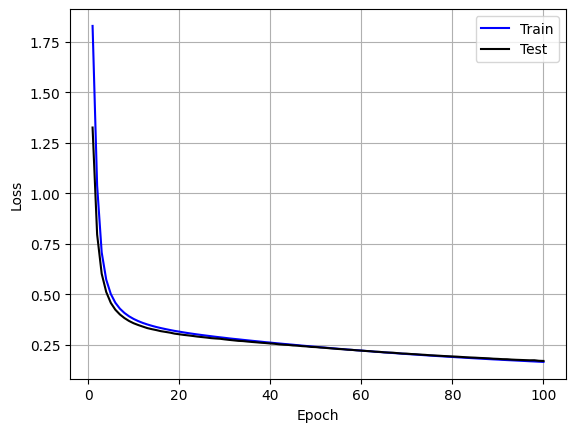

In [19]:
plt.plot(history[:, 0], history[:, 1], c='b', label = 'Train')
plt.plot(history[:, 0], history[:, 3], c='k', label = 'Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

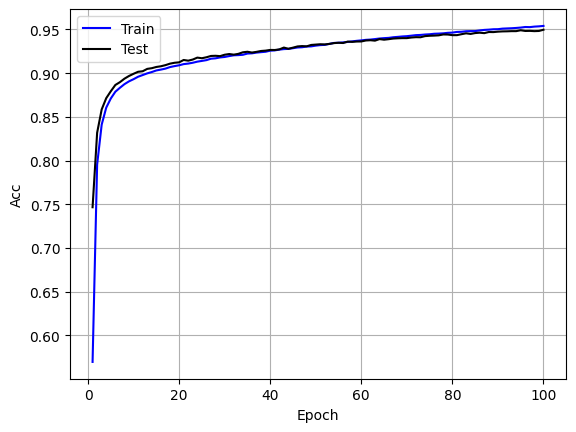

In [20]:
plt.plot(history[:, 0], history[:, 2], c='b', label='Train')
plt.plot(history[:, 0], history[:, 4], c='k', label='Test')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

In [21]:
for image, label in test_loader:
    break

outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

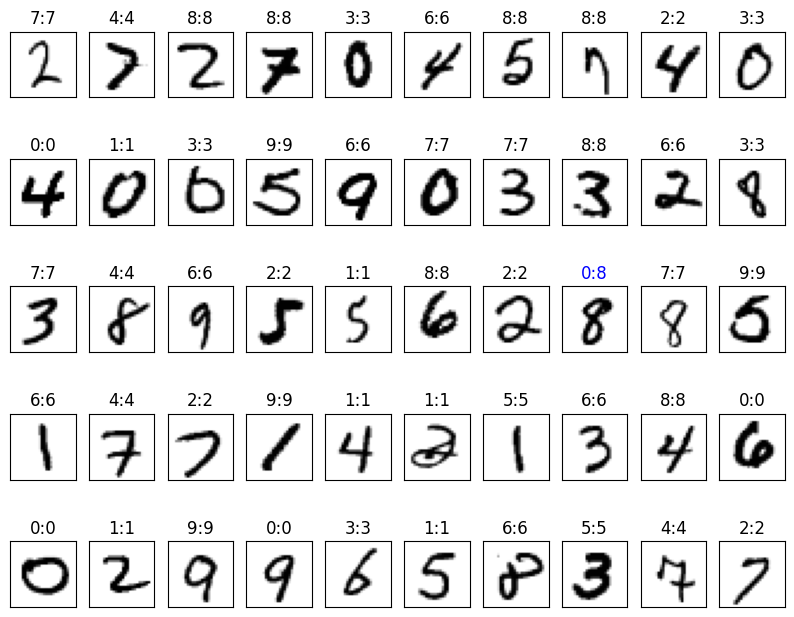

In [22]:
# 처음 50건의 이미지에 대해 "정답:예측"으로 출력

plt.figure(figsize=(10, 8))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
    
  # 넘파이 배열로 변환
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c = 'k'
  else:
    c = 'b'
    
  # 이미지의 범위를 [0, 1] 로 되돌림
  image2 = (image + 1)/ 2
    
  # 이미지 출력
  plt.imshow(image2.reshape(28, 28),cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

#### 은닉층 추가하기

In [25]:
#784입력 10출력을 갖는 2개의 은닉층을 포함한 신경망
class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        self.l1 = nn.Linear(n_input, n_hidden)

        self.l2 = nn.Linear(n_hidden, n_hidden)

        self.l3 = nn.Linear(n_hidden, n_output)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)

        return x5

In [27]:
#초기화
torch.manual_seed(123)

lr = 0.01

net = Net2(n_input, n_output, n_hidden)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr = lr)

num_epoch = 100

history2 = np.zeros((0, 5))

In [28]:
#반복처리

#반복계산 메인 루프
for epoch in range(num_epoch):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    #train
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        predicted = torch.max(outputs, 1)[1]

        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()

    #predict
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        outputs_test = net(inputs_test)

        loss_test = criterion(outputs_test, labels_test)

        #예측 라벨 산출
        predicted_test = torch.max(outputs_test, 1)[1]

        val_loss += loss_test.item()
        val_acc += (predicted_test == labels_test).sum().item()
    
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test

    print (f'Epoch [{epoch+1}/{num_epoch}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch + 1, train_loss, train_acc, val_loss, val_acc])
    history2 = np.vstack((history2, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/100], loss: 2.20163 acc: 0.25380 val_loss: 2.04576, val_acc: 0.49800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/100], loss: 1.75820 acc: 0.60445 val_loss: 1.39271, val_acc: 0.68690


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/100], loss: 1.11284 acc: 0.75650 val_loss: 0.86511, val_acc: 0.80810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.75171 acc: 0.82290 val_loss: 0.63477, val_acc: 0.84380


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.59030 acc: 0.84983 val_loss: 0.52462, val_acc: 0.86360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.50672 acc: 0.86652 val_loss: 0.46400, val_acc: 0.87440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.45680 acc: 0.87538 val_loss: 0.42149, val_acc: 0.88560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.42335 acc: 0.88190 val_loss: 0.39551, val_acc: 0.89020


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.39965 acc: 0.88768 val_loss: 0.37600, val_acc: 0.89350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.38195 acc: 0.89188 val_loss: 0.35886, val_acc: 0.89880


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.36793 acc: 0.89478 val_loss: 0.34926, val_acc: 0.90350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.35633 acc: 0.89802 val_loss: 0.33760, val_acc: 0.90400


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.34649 acc: 0.89965 val_loss: 0.32775, val_acc: 0.90580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.33814 acc: 0.90203 val_loss: 0.32062, val_acc: 0.90760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.33042 acc: 0.90457 val_loss: 0.31807, val_acc: 0.90760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.32382 acc: 0.90602 val_loss: 0.31014, val_acc: 0.91130


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.31777 acc: 0.90760 val_loss: 0.30470, val_acc: 0.91140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.31206 acc: 0.90905 val_loss: 0.30014, val_acc: 0.91410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.30685 acc: 0.91080 val_loss: 0.29439, val_acc: 0.91420


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.30213 acc: 0.91212 val_loss: 0.29149, val_acc: 0.91500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.29752 acc: 0.91372 val_loss: 0.28592, val_acc: 0.91640


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.29328 acc: 0.91495 val_loss: 0.28178, val_acc: 0.91750


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.28876 acc: 0.91608 val_loss: 0.27957, val_acc: 0.91850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.28524 acc: 0.91683 val_loss: 0.27462, val_acc: 0.92080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.28128 acc: 0.91832 val_loss: 0.27169, val_acc: 0.92150


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.27771 acc: 0.91925 val_loss: 0.26890, val_acc: 0.92200


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.27410 acc: 0.92008 val_loss: 0.26614, val_acc: 0.92380


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.27079 acc: 0.92117 val_loss: 0.26244, val_acc: 0.92480


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.26759 acc: 0.92232 val_loss: 0.26266, val_acc: 0.92330


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.26482 acc: 0.92293 val_loss: 0.25895, val_acc: 0.92430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.26133 acc: 0.92375 val_loss: 0.25496, val_acc: 0.92660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.25841 acc: 0.92473 val_loss: 0.25226, val_acc: 0.92750


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.25550 acc: 0.92568 val_loss: 0.25113, val_acc: 0.92570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.25278 acc: 0.92638 val_loss: 0.24732, val_acc: 0.92770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.24958 acc: 0.92757 val_loss: 0.24457, val_acc: 0.93060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.24675 acc: 0.92832 val_loss: 0.24468, val_acc: 0.92760


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.24410 acc: 0.92962 val_loss: 0.24130, val_acc: 0.92830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.24157 acc: 0.93008 val_loss: 0.23740, val_acc: 0.93200


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.23885 acc: 0.93112 val_loss: 0.23471, val_acc: 0.93290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.23615 acc: 0.93165 val_loss: 0.23367, val_acc: 0.93230


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.23373 acc: 0.93223 val_loss: 0.22987, val_acc: 0.93330


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.23094 acc: 0.93273 val_loss: 0.22862, val_acc: 0.93250


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.22848 acc: 0.93410 val_loss: 0.22667, val_acc: 0.93570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.22611 acc: 0.93483 val_loss: 0.22332, val_acc: 0.93510


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.22343 acc: 0.93503 val_loss: 0.22106, val_acc: 0.93450


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.22102 acc: 0.93585 val_loss: 0.21978, val_acc: 0.93630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.21871 acc: 0.93680 val_loss: 0.21706, val_acc: 0.93660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.21631 acc: 0.93753 val_loss: 0.21634, val_acc: 0.93740


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.21396 acc: 0.93825 val_loss: 0.21387, val_acc: 0.93820


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.21179 acc: 0.93885 val_loss: 0.21027, val_acc: 0.93730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.20944 acc: 0.93943 val_loss: 0.20931, val_acc: 0.93880


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.20723 acc: 0.94022 val_loss: 0.20955, val_acc: 0.93580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.20505 acc: 0.94075 val_loss: 0.20476, val_acc: 0.94070


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.20265 acc: 0.94137 val_loss: 0.20285, val_acc: 0.93920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.20042 acc: 0.94237 val_loss: 0.20079, val_acc: 0.94170


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.19844 acc: 0.94278 val_loss: 0.19842, val_acc: 0.94200


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.19652 acc: 0.94383 val_loss: 0.19673, val_acc: 0.94180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.19422 acc: 0.94393 val_loss: 0.19496, val_acc: 0.94240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.19227 acc: 0.94438 val_loss: 0.19378, val_acc: 0.94310


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.19031 acc: 0.94530 val_loss: 0.19109, val_acc: 0.94350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.18842 acc: 0.94562 val_loss: 0.19000, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.18623 acc: 0.94680 val_loss: 0.18821, val_acc: 0.94440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.18460 acc: 0.94670 val_loss: 0.18560, val_acc: 0.94500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.18266 acc: 0.94700 val_loss: 0.18448, val_acc: 0.94500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.18072 acc: 0.94807 val_loss: 0.18253, val_acc: 0.94560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.17906 acc: 0.94828 val_loss: 0.18065, val_acc: 0.94540


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.17725 acc: 0.94932 val_loss: 0.17929, val_acc: 0.94620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.17531 acc: 0.94973 val_loss: 0.17716, val_acc: 0.94660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.17379 acc: 0.94982 val_loss: 0.17561, val_acc: 0.94860


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.17195 acc: 0.95057 val_loss: 0.17436, val_acc: 0.94800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.17031 acc: 0.95122 val_loss: 0.17268, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.16848 acc: 0.95137 val_loss: 0.17091, val_acc: 0.94890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.16689 acc: 0.95198 val_loss: 0.17039, val_acc: 0.94970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.16519 acc: 0.95253 val_loss: 0.16927, val_acc: 0.95030


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.16374 acc: 0.95280 val_loss: 0.16797, val_acc: 0.94960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.16229 acc: 0.95353 val_loss: 0.16562, val_acc: 0.95140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.16060 acc: 0.95377 val_loss: 0.16514, val_acc: 0.95140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.15917 acc: 0.95427 val_loss: 0.16287, val_acc: 0.95140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.15768 acc: 0.95460 val_loss: 0.16263, val_acc: 0.95160


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.15609 acc: 0.95533 val_loss: 0.16008, val_acc: 0.95310


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.15467 acc: 0.95563 val_loss: 0.15934, val_acc: 0.95280


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.15333 acc: 0.95593 val_loss: 0.15825, val_acc: 0.95290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.15187 acc: 0.95628 val_loss: 0.15678, val_acc: 0.95300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.15063 acc: 0.95695 val_loss: 0.15560, val_acc: 0.95410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.14918 acc: 0.95718 val_loss: 0.15532, val_acc: 0.95410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.14785 acc: 0.95778 val_loss: 0.15301, val_acc: 0.95410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.14652 acc: 0.95783 val_loss: 0.15198, val_acc: 0.95440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.14521 acc: 0.95837 val_loss: 0.15014, val_acc: 0.95480


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.14407 acc: 0.95880 val_loss: 0.14956, val_acc: 0.95510


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.14251 acc: 0.95920 val_loss: 0.14938, val_acc: 0.95520


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.14150 acc: 0.95973 val_loss: 0.14768, val_acc: 0.95550


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.14014 acc: 0.95977 val_loss: 0.14766, val_acc: 0.95570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.13901 acc: 0.96013 val_loss: 0.14750, val_acc: 0.95630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.13766 acc: 0.96062 val_loss: 0.14511, val_acc: 0.95620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.13663 acc: 0.96092 val_loss: 0.14406, val_acc: 0.95620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.13549 acc: 0.96138 val_loss: 0.14408, val_acc: 0.95680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.13421 acc: 0.96168 val_loss: 0.14102, val_acc: 0.95690


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.13313 acc: 0.96213 val_loss: 0.14106, val_acc: 0.95700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.13193 acc: 0.96240 val_loss: 0.13980, val_acc: 0.95710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.13093 acc: 0.96290 val_loss: 0.13875, val_acc: 0.95820


In [29]:
print(f'초기상태 손실: {history2[0, 3]:.5f}, 초기상태 정확도: {history2[0,4]:.5f}')
print(f'최종상태 손실: {history2[-1, 3]:.5f}, 최종상태 정확도: {history2[-1,4]:.5f}')

초기상태 손실: 2.04576, 초기상태 정확도: 0.49800
최종상태 손실: 0.13875, 최종상태 정확도: 0.95820


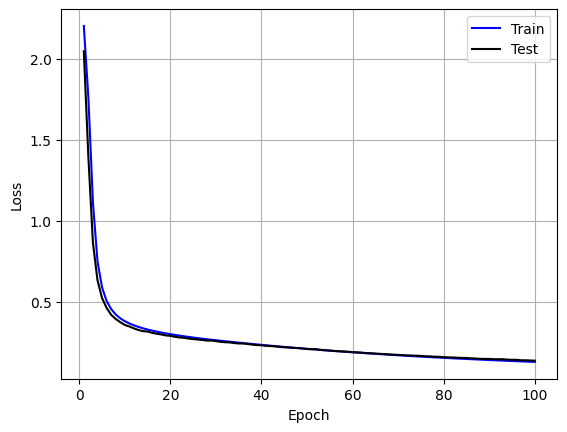

In [30]:
plt.plot(history2[:, 0], history2[:, 1], c='b', label = 'Train')
plt.plot(history2[:, 0], history2[:, 3], c='k', label = 'Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

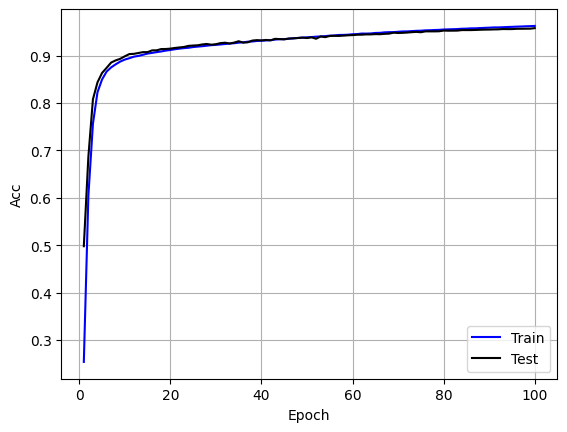

In [31]:
plt.plot(history2[:, 0], history2[:, 2], c='b', label='Train')
plt.plot(history2[:, 0], history2[:, 4], c='k', label='Test')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()